<a href="https://colab.research.google.com/github/StephaniePC1/ThisIsWhatIDoNow/blob/master/Final_GPVII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Guided Project: Winning Jeopardy

For this guided project, we were given a dataset of Jeopardy questions. You can download the dataset [here](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file/). With this data, we are supposed to find possible patterns in the questions to help better someone's chances of winning the game show.

Each row is one of the questions from the show along with other data about that question. Here is the dataset library:

`Show Number` -- the Jeopardy episode number of the show this question was in.

`Air Date` -- the date the episode aired.

`Round` -- the round of Jeopardy that the question was asked in. Jeopardy has several rounds as each episode progresses.

`Category` -- the category of the question.

`Value` -- the number of dollars answering the question correctly is worth.

`Question` -- the text of the question.

`Answer` -- the text of the answer.

Furthermore, we wanted to look into ways about how to study efficiently. So, we investigated the top answers within a given amount of games to see if there was a strong pattern for some answers. Also, we checked the categories that would appear the most within that set amount of games as well. 

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams
from scipy.stats import chisquare,chi2_contingency
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image

nltk.download('stopwords')
nltk.download('punkt')

import csv

path = 'https://github.com/StephaniePC1/ThisIsWhatIDoNow/raw/master/JEOPARDY_CSV.zip'
jeopardy = pd.read_csv(path, compression='zip')

In [ ]:
jeopardy.head(10)

In [ ]:
jeopardy.columns

In [ ]:
jeopardy.columns = ['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question', 'Answer']

In [ ]:
import re

def normalize_text(text):
    text = text.lower()
    text = re.sub("[^A-Za-z0-9\s]", "", text)
    text = re.sub("\s+", " ", text)
    return text

def normalize_values(text):
    text = re.sub("[^A-Za-z0-9\s]", "", text)
    try:
        text = int(text)
    except Exception:
        text = 0
    return text

In [ ]:
jeopardy['Answer'] = jeopardy['Answer'].astype(str)

In [ ]:
jeopardy["clean_question"] = jeopardy["Question"].apply(normalize_text)
jeopardy["clean_value"] = jeopardy["Value"].apply(normalize_values)
jeopardy["clean_answer"] = jeopardy["Answer"].apply(normalize_text)

In [ ]:
jeopardy.head(5)

In [ ]:
jeopardy["Air Date"] = pd.to_datetime(jeopardy["Air Date"])

In [ ]:
jeopardy.dtypes

In [ ]:
def count_matches(row):
    split_answer = row["Answer"].split()
    split_question = row["clean_question"].split()
    if "the" in split_answer:
        split_answer.remove("the")
    if len(split_answer) == 0:
        return 0
    match_count = 0
    for item in split_answer:
        if item in split_question:
            match_count += 1
    return match_count / len(split_answer)

In [ ]:
jeopardy["answer_in_question"] = jeopardy.apply(count_matches, axis=1)

In [ ]:
j_mean= jeopardy["answer_in_question"].mean()
print(round(j_mean ,4))

After taking the average, we found out that only 3% of the question is made of the answer. So, you wouldn't be able to rely on figuring out the answer just because you hear a certain question.

In [ ]:
question_overlap = []
terms_used = set()

jeopardy = jeopardy.sort_values("Air Date")

for i, row in jeopardy.iterrows():
        split_question = row["clean_question"].split(" ")
        split_question = [q for q in split_question if len(q) > 5]
        match_count = 0
        for word in split_question:
            if word in terms_used:
                match_count += 1
        for word in split_question:
            terms_used.add(word)
        if len(split_question) > 0:
            match_count /= len(split_question)
        question_overlap.append(match_count)
jeopardy["question_overlap"] = question_overlap

j_mean_2=jeopardy["question_overlap"].mean()
print(round(j_mean_2 ,4))

(-0.5, 1199.5, 799.5, -0.5)

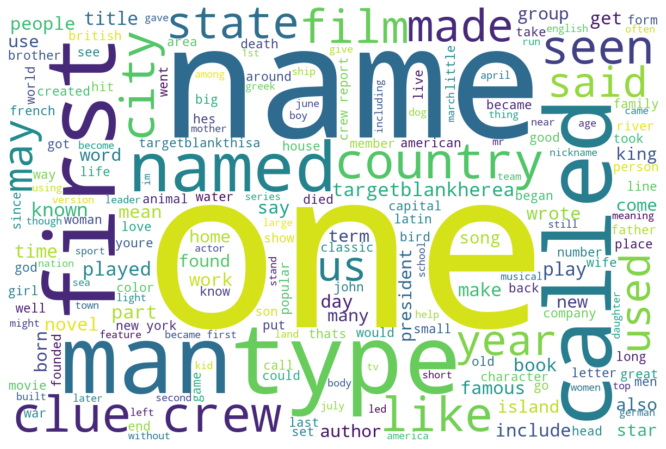

In [ ]:
clean= jeopardy['clean_question']
text = ""

for question in clean:
    text = text + question + " "
    
wordcloud = WordCloud(width=1200, height=800, stopwords=stopwords.words('english'), background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

* It appears that a high percentage of questions are recycled, approximately 87%. However, this may be due to the fact that certain words are repeated many times but not neccesarily in the same context. 

* To illustrate this point, we included a `wordcloud` plot to help us visualize which words are most frequently used in the questions. 

In [ ]:
def determine_value(row):
    value = 0
    if row["clean_value"] > 800:
        value = 1
    return value

jeopardy["high_value"] = jeopardy.apply(determine_value, axis=1)

In [ ]:
def count_usage(term):
    low_count = 0
    high_count = 0
    for i, row in jeopardy.iterrows():
        if term in row["clean_question"].split(" "):
            if row["high_value"] == 1:
                high_count += 1
            else:
                low_count += 1
    return high_count, low_count

In [ ]:
from random import choice

terms_used_list = list(terms_used)
comparison_terms = [choice(terms_used_list) for _ in range(10)]

observed_expected = []

for term in comparison_terms:
    observed_expected.append(count_usage(term))

observed_expected

[(0, 1),
 (0, 1),
 (1, 0),
 (0, 1),
 (4, 13),
 (0, 1),
 (0, 1),
 (4, 4),
 (0, 5),
 (2, 21)]

In [ ]:
from scipy.stats import chisquare
import numpy as np

high_value_count = jeopardy[jeopardy["high_value"] == 1].shape[0]
low_value_count = jeopardy[jeopardy["high_value"] == 0].shape[0]

chi_squared = []
for obs in observed_expected:
    total = sum(obs)
    total_prop = total / jeopardy.shape[0]
    high_value_exp = total_prop * high_value_count
    low_value_exp = total_prop * low_value_count
    
    observed = np.array([obs[0], obs[1]])
    expected = np.array([high_value_exp, low_value_exp])
    chi_squared.append(chisquare(observed, expected))

chi_squared

[Power_divergenceResult(statistic=0.3949764642333513, pvalue=0.5296950912486695),
 Power_divergenceResult(statistic=0.3949764642333513, pvalue=0.5296950912486695),
 Power_divergenceResult(statistic=2.5317964247338085, pvalue=0.11157312838169751),
 Power_divergenceResult(statistic=0.3949764642333513, pvalue=0.5296950912486695),
 Power_divergenceResult(statistic=0.1917508971280775, pvalue=0.6614633388942732),
 Power_divergenceResult(statistic=0.3949764642333513, pvalue=0.5296950912486695),
 Power_divergenceResult(statistic=0.3949764642333513, pvalue=0.5296950912486695),
 Power_divergenceResult(statistic=1.8535457779343205, pvalue=0.17337156193933898),
 Power_divergenceResult(statistic=1.974882321166757, pvalue=0.15993058334750943),
 Power_divergenceResult(statistic=4.361382888080138, pvalue=0.03676245094199119)]

With the given frequencies, all of them are lower than 5, which hurts the validity of the chi-squared test. Also, none of the frequencies had a big difference in usage of high and low values. So, it would be better to run the test with higher frequency terms. 

#Research: Efficient Studying

##Introduction

  Jeopardy! as a game show requires months, if not years, of preparation to prepare for. Because of this huge preparation requirement, it makes sense to try and optimize our studying by focusing on topics or subjects that are more likely appear. We will be looking at the data from game 4680 to 4999 to determine if there are answers that frequently appear. Jeopardy! is also known for their fun and unique categories, so we will also analyze the categories to see if there is a trend of repeated general categories.

In [ ]:
counts=jeopardy["clean_answer"].value_counts()
counts

china                                   216
australia                               215
chicago                                 196
japan                                   196
france                                  193
                                       ... 
your little finger                        1
harry potter and the sorcerors stone      1
punji stick                               1
i conquered                               1
the ntsb                                  1
Name: clean_answer, Length: 75014, dtype: int64

In [ ]:
repeat_answers = jeopardy.loc[jeopardy['clean_answer'].isin(counts.index[counts > 2])]

In [ ]:
repeat_answers2= jeopardy.loc[jeopardy['clean_answer'].isin(counts.index[counts > 5])]

In [ ]:
repeat_answers3= jeopardy.loc[jeopardy['clean_answer'].isin(counts.index[counts > 10])]

In [ ]:
repeat_answers4 = jeopardy.loc[jeopardy['clean_answer'].isin(counts.index[counts > 161])]

In [ ]:
round(len(repeat_answers)/len(jeopardy) ,4)*100

68.67

In [ ]:
round(len(repeat_answers2)/len(jeopardy) ,5)*100

50.856

In [ ]:
round(len(repeat_answers3)/len(jeopardy) ,4)*100

35.82

In [ ]:
repeat_answers4["clean_answer"].value_counts()

china         216
australia     215
japan         196
chicago       196
france        193
india         185
california    180
canada        176
spain         171
mexico        164
Name: clean_answer, dtype: int64

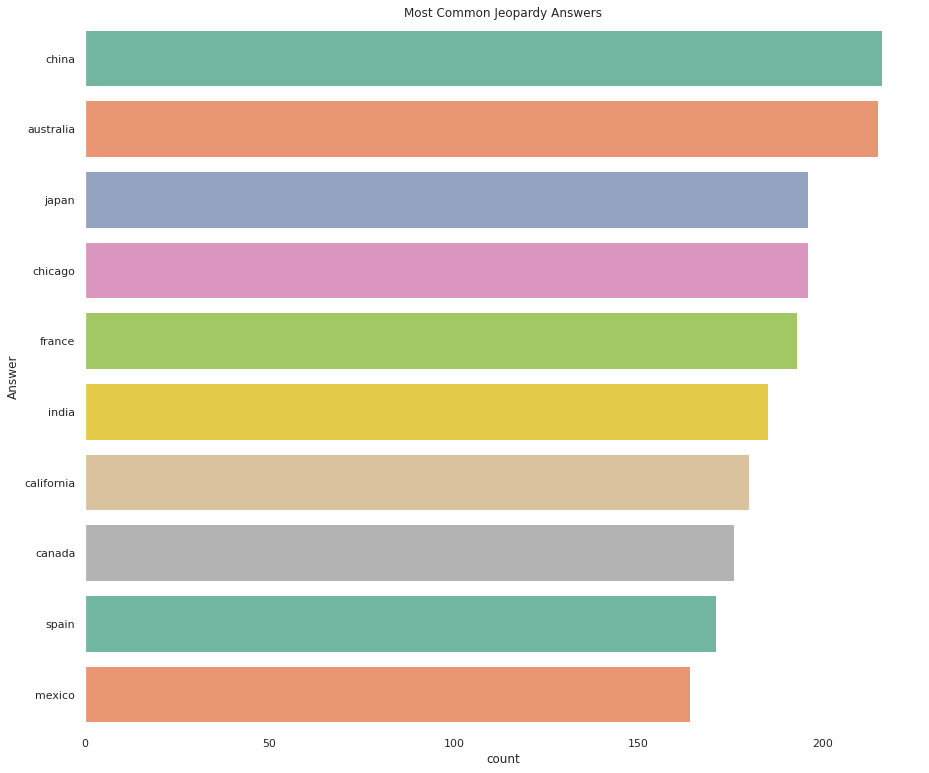

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15,13)})
top_answers=sns.countplot(y="clean_answer", data= repeat_answers4, palette="Set2", order = repeat_answers4["clean_answer"].value_counts().index)
top_answers.set_title('Most Common Jeopardy Answers')
top_answers.set_ylabel('Answer')
top_answers.set_facecolor('white')

In [ ]:
counts=jeopardy["Category"].value_counts()
counts

BEFORE & AFTER                 547
SCIENCE                        519
LITERATURE                     496
AMERICAN HISTORY               418
POTPOURRI                      401
                              ... 
THE MARS PATHFINDER MISSION      1
RELIGIOUS TERMS                  1
PRESIDENTS & THE MOVIES          1
SPORTS & THE MOVIES              1
BILLBOARD HOT 100 HISTORY        1
Name: Category, Length: 27995, dtype: int64

In [ ]:
repeat_categories = jeopardy.loc[jeopardy['Category'].isin(counts.index[counts > 5])]

In [ ]:
round(len(repeat_categories)/len(jeopardy) ,6)*100

49.7027

In [ ]:
repeat_categories2 = jeopardy.loc[jeopardy['Category'].isin(counts.index[counts > 10])]

In [ ]:
round(len(repeat_categories2)/len(jeopardy) ,6)*100

38.2598

In [ ]:
repeat_categories3 = jeopardy.loc[jeopardy['Category'].isin(counts.index[counts > 340])]

In [ ]:
repeat_categories3["Category"].value_counts()

BEFORE & AFTER             547
SCIENCE                    519
LITERATURE                 496
AMERICAN HISTORY           418
POTPOURRI                  401
WORLD HISTORY              377
WORD ORIGINS               371
COLLEGES & UNIVERSITIES    351
HISTORY                    349
SPORTS                     342
Name: Category, dtype: int64

Text(0, 0.5, 'Category')

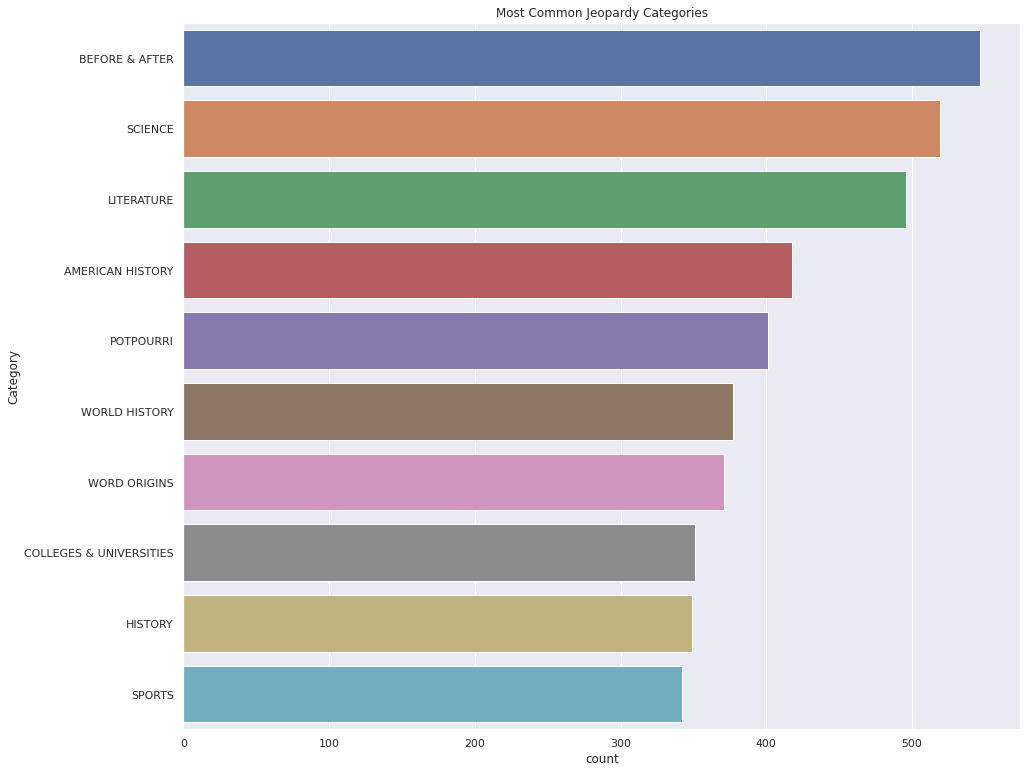

In [ ]:
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15,13)})
top_categories=sns.countplot(y="Category", data= repeat_categories3,  order = repeat_categories3["Category"].value_counts().index)
top_categories.set_title('Most Common Jeopardy Categories')
top_categories.set_ylabel('Category')

In [ ]:
68/319

0.21316614420062696

##Conclusion

  The results of our analysis finds that 69% of the answers on Jeopardy! are repeated at least once and 51% are repeated 5 times. This means that if it would pay to look at the answers that are commonly given so that we can learn trivia aboout those topics. The top 10 jeopardy answers are all locations with China, Australia, Chicago, Japan, and France taking the top five positions. This indicates that most answers will be country or city based and that it would benefit a prospective Jeopardy! contest should learn trivia about these places.

  In addition to looking at the answers to assess which topics are best to study, we also analyzed the categories to see which subjects would be best to study. Each Category in Jeopardy! is used up to five times per episode as there are five biding options. In general, Jeopardy! categories are used more than once 50% of the time, and more than twice times 38% of the time. The top 10 categories all appeared more than 340 times, so they appeared at least 68 times in the 319 games we observed so the top ten categories appear in over a fifth of the games. This means that it would behoove a prospective Jeopardy! contestant to study the the commonly used subjects and especially stress the topics/answers we found to most often appear.